# 영화 관객수 예측 모델 개발

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

import warnings
warnings.filterwarnings("ignore")

In [2]:
movies_train = pd.read_csv('movies_train.csv')
movies_test = pd.read_csv('movies_test.csv')
movies_submission = pd.read_csv('submission.csv')

## 0. 데이터 전처리

In [3]:
movies_train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [4]:
print(movies_train.shape)

(600, 12)


In [5]:
movies_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [6]:
pd.options.display.float_format = '{:.1f}'.format
movies_train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.0,270.0,600.0,600.0,600.0,600.0
mean,100.9,1050442.9,0.9,151.1,3.7,708181.8
std,18.1,1791408.3,1.2,165.7,2.4,1828005.9
min,45.0,1.0,0.0,0.0,0.0,1.0
25%,89.0,20380.0,0.0,17.0,2.0,1297.2
50%,100.0,478423.6,0.0,82.5,3.0,12591.0
75%,114.0,1286568.6,2.0,264.0,4.0,479886.8
max,180.0,17615314.0,5.0,869.0,25.0,14262766.0


In [7]:
pd.reset_option('display.float_format')

In [8]:
movies_train.isna().sum() # 결측값 존재

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [9]:
# dir_prev_bfnum 변수 결측값을 0으로 대체하기
movies_train['dir_prev_bfnum'].fillna(0, inplace= True)
movies_train.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
dtype: int64

In [10]:
# test 데이터에도 동일하게 적용
movies_test['dir_prev_bfnum'].fillna(0, inplace= True)

In [11]:
# release_time 변수를 년/월/일 변수로 분리
from datetime import datetime
movies_train['release_time']=pd.to_datetime(movies_train['release_time'])
movies_train['release_year'] = movies_train['release_time'].dt.year
movies_train['release_month'] = movies_train['release_time'].dt.month
movies_train['release_day'] = movies_train['release_time'].dt.day
movies_train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,release_year,release_month,release_day
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,2012,11,22
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,2015,11,19
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,2013,6,5
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866,2012,7,12
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387,2010,11,4


## 1. EDA

### 1. distributor : 배급사

In [12]:
# 배급사별 배급한 영화 수
distributor_counts=pd.DataFrame(movies_train['distributor'].value_counts()).reset_index()
distributor_counts.columns=['distributor','counts']
distributor_counts

,distributor,counts
0,CJ 엔터테인먼트,54
1,롯데엔터테인먼트,52
2,(주)NEW,30
3,(주)마운틴픽쳐스,29
4,인디스토리,26
...,...,...
164,(주)두타연,1
165,디마엔터테인먼트,1
166,tvN,1
167,전주국제영화제,1


Text(0.5, 1.0, '각 배급사 별 영화의 수 (5건 이상)')

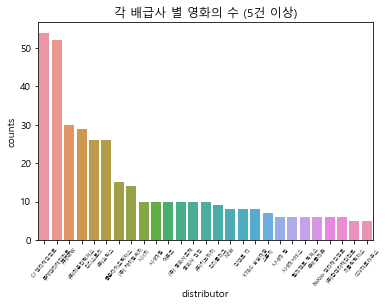

In [13]:
# 배급사별 영화 수 그래프
bar_distributor_counts=plt.subplots()
plt.xticks(rotation = 50, fontsize = 5)
plt.yticks(fontsize=10)
bar_distributor_counts=sns.barplot(x='distributor',y='counts',data=distributor_counts[distributor_counts['counts']>=5])
bar_distributor_counts.set_title("각 배급사 별 영화의 수 (5건 이상)", fontsize=12)

In [14]:
# 배급사별 평균 관객 수
dist_bon_mean=pd.DataFrame(movies_train.groupby(['distributor'],as_index=False).mean().sort_values('box_off_num',axis=0,ascending=False))
dist_bon_mean

,distributor,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,release_year,release_month,release_day
49,CJ E&M Pictures,115.000000,4.111671e+06,0.500000,335.000000,8.000000,4.122337e+06,2011.000000,5.500000,6.5
21,(주)쇼박스,126.538462,1.370236e+06,1.807692,360.384615,3.923077,3.386656e+06,2012.884615,7.076923,17.5
27,(주)아이필름코퍼레이션,121.000000,7.250000e+01,2.000000,458.000000,3.000000,3.117859e+06,2013.000000,8.000000,14.0
96,쇼박스(주)미디어플렉스,111.500000,5.000000e-01,0.500000,293.000000,2.500000,2.634823e+06,2010.500000,6.000000,15.5
121,영구아트무비,103.000000,7.855474e+06,1.000000,31.000000,5.000000,2.541603e+06,2010.000000,12.000000,29.0
...,...,...,...,...,...,...,...,...,...,...
68,나우콘텐츠,74.000000,1.556000e+03,1.000000,0.000000,2.000000,5.400000e+01,2014.000000,4.000000,17.0
131,위드시네마,86.000000,0.000000e+00,0.000000,0.000000,4.000000,4.600000e+01,2010.000000,11.000000,25.0
92,사람과 사람들,94.000000,0.000000e+00,0.000000,55.000000,2.000000,4.200000e+01,2012.000000,8.000000,23.0
65,고구마공작소,78.000000,1.761531e+07,1.000000,27.000000,3.000000,8.000000e+00,2015.000000,9.000000,3.0


Text(0.5, 1.0, '각 배급사 별 관객의 수(50000명 이상)')

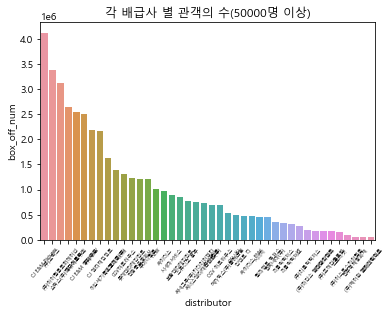

In [15]:
# 배급사 별 관객 수 그래프
bar_dist_bon_mean=plt.subplots()
plt.xticks(rotation = 50, fontsize=5)
plt.yticks(fontsize=10)
bar_dist_bon_mean=sns.barplot(x='distributor',y='box_off_num',data=dist_bon_mean[dist_bon_mean['box_off_num']>50000])
bar_dist_bon_mean.set_title("각 배급사 별 관객의 수(50000명 이상)", fontsize=12)

* 영화를 많이 배급하는 배급사의 평균 관객수가 높지는 않다. 상관성이 낮음

### 2. genre : 장르

In [16]:
# 장르별 영화 수
genre_counts=pd.DataFrame(movies_train['genre'].value_counts()).reset_index()
genre_counts.columns=['genre','counts']
genre_counts

,genre,counts
0,드라마,221
1,다큐멘터리,93
2,멜로/로맨스,78
3,코미디,53
4,공포,42
5,액션,28
6,느와르,27
7,애니메이션,21
8,미스터리,17
9,SF,13


Text(0.5, 1.0, '각 장르 별 영화의 수 (5건 이상)')

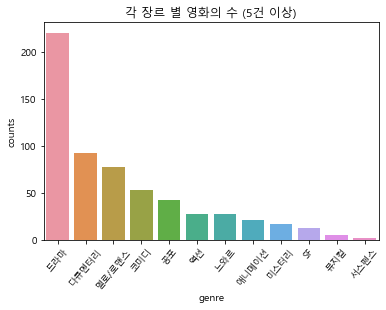

In [17]:
# 장르별 영화 수 그래프
bar_genre_counts=plt.subplots()
plt.xticks(rotation = 50, fontsize=9)
plt.yticks(fontsize = 10)
bar_genre_counts=sns.barplot(x='genre',y='counts',data=genre_counts)
bar_genre_counts.set_title("각 장르 별 영화의 수 (5건 이상)", fontsize=12)

In [18]:
# 장르별 평균 관객 수
genre_bon_mean=pd.DataFrame(movies_train.groupby(['genre'],as_index=False).mean().sort_values('box_off_num',axis=0,ascending=False))
genre_bon_mean

,genre,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,release_year,release_month,release_day
2,느와르,115.370370,7.749172e+05,1.296296,311.074074,3.592593,2.263695e+06,2012.851852,6.481481,17.555556
10,액션,114.464286,1.061149e+06,1.857143,337.535714,3.607143,2.203974e+06,2012.642857,7.500000,18.821429
0,SF,101.384615,1.238218e+06,1.307692,197.307692,3.692308,1.788346e+06,2013.000000,6.846154,14.230769
11,코미디,105.264151,9.466686e+05,1.094340,209.075472,4.735849,1.193914e+06,2012.452830,6.660377,17.358491
4,드라마,104.651584,3.673737e+05,0.814480,164.484163,3.647059,6.256898e+05,2012.610860,6.990950,16.271493
1,공포,100.214286,5.398694e+05,1.095238,176.380952,3.880952,5.908325e+05,2012.857143,7.261905,17.547619
7,미스터리,102.588235,5.839898e+05,1.235294,117.352941,2.882353,5.275482e+05,2013.294118,7.470588,14.470588
5,멜로/로맨스,96.641026,6.158363e+05,0.987179,135.782051,3.410256,4.259680e+05,2013.051282,6.923077,16.448718
9,애니메이션,82.571429,2.535000e+03,0.047619,44.619048,5.666667,1.819267e+05,2013.142857,7.333333,18.047619
8,서스펜스,112.000000,2.671162e+05,1.000000,111.000000,3.000000,8.261100e+04,2013.500000,6.500000,17.500000


Text(0.5, 1.0, '각 장르 별 관객의 수')

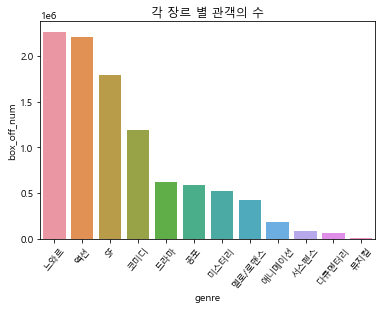

In [19]:
# 장르별 관객 수 그래프
bar_genre_bon_mean=plt.subplots()
plt.xticks(rotation = 50, fontsize=9)
plt.yticks(fontsize = 10)
bar_genre_bon_mean=sns.barplot(x='genre',y='box_off_num',data=genre_bon_mean)
bar_genre_bon_mean.set_title("각 장르 별 관객의 수", fontsize=12)

### 3. release_time: 개봉일

In [20]:
# 년도별 평균 관객 수
year_bon_mean=pd.DataFrame(movies_train.groupby(['release_year'],as_index=False).mean().sort_values('box_off_num',axis=0,ascending=False))
year_bon_mean

,release_year,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,release_month,release_day
3,2013,101.505263,343786.224561,0.863158,114.284211,3.800000,1.007358e+06,7.347368,17.526316
2,2012,101.295455,391948.229167,1.011364,136.579545,3.465909,9.457252e+05,6.568182,16.738636
1,2011,101.600000,487726.002083,0.612500,133.637500,3.737500,6.288671e+05,6.775000,15.250000
5,2015,100.258333,713280.643194,1.191667,163.041667,3.450000,5.958692e+05,7.316667,16.983333
4,2014,98.645669,376068.879265,0.826772,154.393701,3.543307,5.938845e+05,6.976378,15.952756
0,2010,103.044444,489954.890741,0.644444,199.233333,4.388889,5.416582e+05,6.944444,16.744444


Text(0.5, 1.0, '각 년도별 관객의 수')

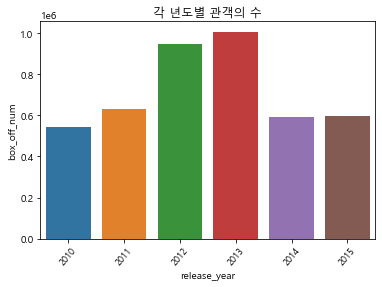

In [21]:
# 년도별 관객 수 그래프
bar_year_bon_mean=plt.subplots()
plt.xticks(rotation = 50, fontsize = 9)
plt.yticks(fontsize = 10)
bar_year_bon_mean=sns.barplot(x='release_year',y='box_off_num',data=year_bon_mean)
bar_year_bon_mean.set_title("각 년도별 관객의 수", fontsize=12)

In [22]:
# 월별 평균 관객 수
month_bon_mean=pd.DataFrame(movies_train.groupby(['release_month'],as_index=False).mean().sort_values('box_off_num',axis=0,ascending=False))
month_bon_mean

,release_month,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,release_year,release_day
0,1,105.205128,669448.106838,1.102564,213.000000,3.205128,1.365931e+06,2012.743590,18.794872
11,12,105.122449,732059.164966,0.959184,184.306122,3.938776,1.288248e+06,2012.959184,13.897959
6,7,96.775510,442051.346939,0.755102,124.142857,4.163265,1.113807e+06,2012.755102,16.244898
7,8,101.218182,383681.891212,0.890909,177.254545,4.163636,1.029162e+06,2012.854545,17.054545
8,9,99.550000,773930.630556,0.816667,124.233333,3.833333,7.315286e+05,2012.500000,14.116667
1,2,106.741935,449489.233871,0.870968,163.838710,4.419355,6.630252e+05,2012.645161,16.806452
4,5,103.526316,441757.230994,0.807018,145.614035,3.807018,5.756852e+05,2012.491228,18.684211
5,6,100.379310,209894.759770,0.793103,113.000000,3.517241,5.122865e+05,2012.620690,16.482759
10,11,101.597222,531993.605324,0.875000,147.291667,3.250000,4.956539e+05,2012.736111,17.152778
9,10,97.033333,351079.612500,1.166667,162.166667,3.266667,3.859042e+05,2013.133333,18.150000


Text(0.5, 1.0, '각 월별 관객의 수')

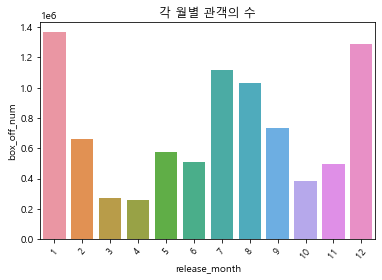

In [23]:
# 월별 관객 수 그래프
bar_month_bon_mean=plt.subplots()
plt.xticks(rotation = 50, fontsize = 9)
plt.yticks(fontsize = 10)
bar_month_bon_mean=sns.barplot(x='release_month',y='box_off_num',data=month_bon_mean)
bar_month_bon_mean.set_title("각 월별 관객의 수", fontsize=12)

### 4. time: 상영시간(분)

In [24]:
# 상영시간별 영화 수
time_counts=pd.DataFrame(movies_train['time'].value_counts()).reset_index()
time_counts.columns=['time','counts']
time_counts=time_counts.sort_values(by="time", ascending=True)
time_counts

,time,counts
85,45,1
70,60,1
62,61,2
60,62,2
69,63,1
...,...,...
82,153,1
83,156,1
84,163,1
73,166,1


Text(0.5, 1.0, '상영시간별 영화 수')

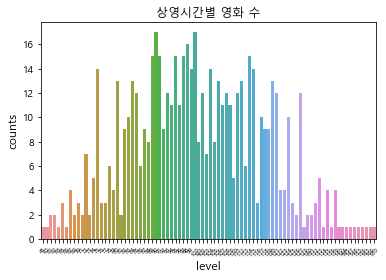

In [25]:
# 상영시간별 영화 수 그래프
bar_time_counts=plt.subplots()
plt.xticks(rotation = 50, fontsize=6)
plt.yticks(fontsize=10)
bar_time_counts=sns.barplot(x='time',y='counts',data=time_counts)
bar_time_counts.set_xlabel('level',fontsize=12)
bar_time_counts.set_ylabel('counts',fontsize=12)
bar_time_counts.set_title("상영시간별 영화 수", fontsize=12)

In [26]:
# 상영시간 범주화해서 다시 확인
bins = list(range(45, 180, 9)) # 구간 나누기
bins_label = [str(x)+"이상 "+str(x+9)+"미만" for x in bins]
movies_train["level"] = pd.cut(movies_train["time"], bins, right=False, labels=bins_label[:-1])

In [27]:
# 상영시간 구간별 영화 수 데이터프레임 만들기
time_movie_counts=movies_train["level"].value_counts()
time_movie_counts=pd.DataFrame(movies_train['level'].value_counts()).reset_index()
time_movie_counts.columns=['level','counts']
time_movie_counts

,level,counts
0,90이상 99미만,121
1,99이상 108미만,104
2,108이상 117미만,91
3,81이상 90미만,84
4,117이상 126미만,74
5,72이상 81미만,57
6,126이상 135미만,28
7,63이상 72미만,16
8,135이상 144미만,10
9,54이상 63미만,5


Text(0.5, 1.0, '상영시간 구간별 영화 수')

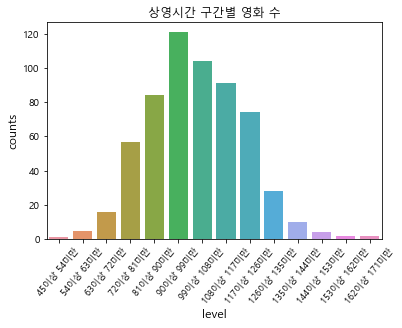

In [28]:
# 상영시간 구간별 영화 수 그래프
bar_time_movie_counts=plt.subplots()
plt.xticks(rotation = 50, fontsize=9)
plt.yticks(fontsize=10)
plt.rcParams["font.size"] = 10
bar_time_movie_counts=sns.barplot(x='level',y='counts',data=time_movie_counts)
bar_time_movie_counts.set_xlabel('level',fontsize=12)
bar_time_movie_counts.set_ylabel('counts',fontsize=12)
bar_time_movie_counts.set_title("상영시간 구간별 영화 수", fontsize=12)

* 90분대의 영화가 가장 많고, 러닝타임 평균인 100분 근처의 러닝타임 영화가 훨씬 많다. 80분 이하이거나 120분 이상인 영화가 상대적으로 훨씬 적다. 

In [29]:
# 상영시간과 관객 수의 상관관계
movies_train[["time","box_off_num"]].corr(method='pearson')

,time,box_off_num
time,1.000000,0.441452
box_off_num,0.441452,1.000000


<AxesSubplot:xlabel='time', ylabel='box_off_num'>

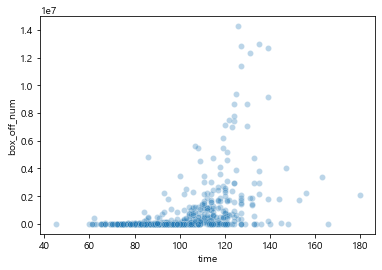

In [30]:
# 상영시간과 관객 수의 관계 그래프
sns.scatterplot(data=movies_train, x='time', y='box_off_num', alpha=0.3)

<AxesSubplot:xlabel='time', ylabel='box_off_num'>

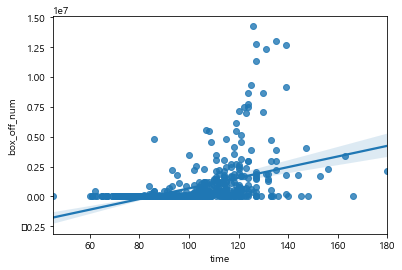

In [31]:
sns.regplot(data=movies_train, x='time', y='box_off_num')

* 높은 관객 수를 기록 한 영화들은 대게 120~140분 러닝타임의 영화다.

### 5. screening_rat : 상영등급

In [32]:
# 상영등급별 영화 수
scr_rat_counts = movies_train['screening_rat'].value_counts().reset_index()
scr_rat_counts.columns=['screening_rat','counts']
scr_rat_counts

,screening_rat,counts
0,청소년 관람불가,204
1,15세 관람가,202
2,12세 관람가,102
3,전체 관람가,92


Text(0.5, 1.0, '상영등급별 영화 수')

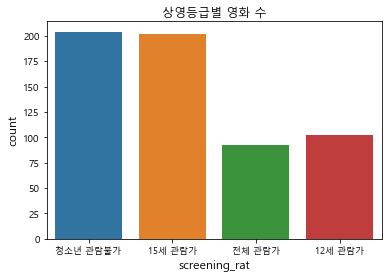

In [33]:
# 상영등급별 영화 수 그래프
scr_rat_counts_plot = plt.subplots()
plt.xticks(fontsize=9)
plt.yticks(fontsize=10)
scr_rat_counts_plot = sns.countplot('screening_rat', data=movies_train)
scr_rat_counts_plot.set_xlabel('screening_rat', fontsize=12)
scr_rat_counts_plot.set_ylabel('count', fontsize=12)
scr_rat_counts_plot.set_title("상영등급별 영화 수", fontsize=12)

In [34]:
# 상영등급별 관객 수
pd.options.display.float_format = '{:.1f}'.format
scr_rat_bfnum = movies_train[['screening_rat','box_off_num']].groupby('screening_rat').sum().sort_values('box_off_num').reset_index()
scr_rat_bfnum.columns=['screening_rat','box_off_num']
scr_rat_bfnum

,screening_rat,box_off_num
0,전체 관람가,12429242
1,청소년 관람불가,74292991
2,12세 관람가,86188052
3,15세 관람가,251998766


Text(0.5, 1.0, '상영등급별 관객 수')

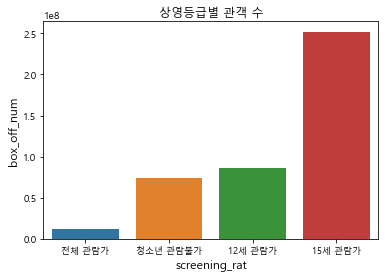

In [35]:
# 상영등급별 관객 수 그래프
scr_rat_plot = plt.subplots()
plt.xticks(fontsize=9)
plt.yticks(fontsize=10)
scr_rat_plot = sns.barplot(x='screening_rat', y='box_off_num', data=scr_rat_bfnum)
scr_rat_plot.set_xlabel('screening_rat',fontsize=12)
scr_rat_plot.set_ylabel('box_off_num', fontsize=12)
scr_rat_plot.set_title("상영등급별 관객 수", fontsize=12)

* 15세 관람가 > 12세 관람가 > 청소년 관람불가 > 전체 관람가 순으로 관객 수가 많다.

In [36]:
# 상영등급별 평균 관객 수
scr_rat_bfnum_avg = movies_train[['screening_rat','box_off_num']].groupby('screening_rat').mean().sort_values('box_off_num').reset_index()
scr_rat_bfnum_avg.columns= ['screening_rat','box_off_num']
scr_rat_bfnum_avg

,screening_rat,box_off_num
0,전체 관람가,135100.5
1,청소년 관람불가,364181.3
2,12세 관람가,844980.9
3,15세 관람가,1247518.6


### 6. director : 감독이름

In [37]:
# 감독별 제작에 참여한 영화 수
dir_counts = pd.DataFrame(movies_train['director'].value_counts()).reset_index()
dir_counts.columns=['director','counts']
dir_counts

,director,counts
0,홍상수,7
1,신재호,4
2,노진수,4
3,우민호,4
4,전규환,4
...,...,...
467,윤기형,1
468,전윤수,1
469,봉준호,1
470,이조훈,1


Text(0.5, 1.0, '감독별 제작에 참여한 영화 수 (3개 이상)')

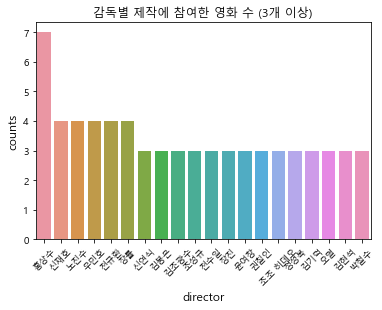

In [38]:
# 감독별 제작에 참여한 영화 수 (3개 이상) 그래프
dir_counts_3 = dir_counts[(dir_counts['counts'] > 2)]
dir_counts_3

dir_counts_3_plot = plt.subplots()
dir_counts_3_plot = sns.barplot(x='director', y='counts', data=dir_counts_3)
plt.xticks(rotation=45, fontsize=9)
plt.yticks(fontsize=10)
dir_counts_3_plot.set_xlabel('director', fontsize=12)
dir_counts_3_plot.set_ylabel('counts', fontsize=12)
dir_counts_3_plot.set_title("감독별 제작에 참여한 영화 수 (3개 이상)", fontsize=12)

In [39]:
# 제작에 참여한 영화 수별 감독 수
by_counts = pd.DataFrame(dir_counts['counts'].value_counts()).reset_index()
by_counts.columns = ['num_movies','dir_counts']
by_counts

,num_movies,dir_counts
0,1,373
1,2,79
2,3,14
3,4,5
4,7,1


Text(0.5, 1.0, '제작에 참여한 영화 수별 감독 수')

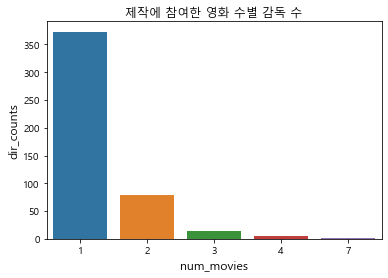

In [40]:
# 제작에 참여한 영화 수별 감독 수 그래프
by_counts_plot = plt.subplots()
by_counts_plot = sns.barplot(x='num_movies', y='dir_counts', data=by_counts)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
by_counts_plot.set_xlabel('num_movies', fontsize=12)
by_counts_plot.set_ylabel('dir_counts', fontsize=12)
by_counts_plot.set_title("제작에 참여한 영화 수별 감독 수", fontsize=12)

* 제작 영화 수는 1~3개 사이에 대부분이 분포하고 있으며 1개인 경우에서 관측값이 압도적으로 많다.

In [41]:
# 감독별 관객 수
dir_bfnum = movies_train[['director','box_off_num']].groupby('director').sum().sort_values('box_off_num', ascending=False).reset_index()
dir_bfnum.columns=['director','box_off_num']
dir_bfnum.sort_values(by=['box_off_num'],ascending=False)

,director,box_off_num
0,최동훈,25690504
1,이석훈,16425919
2,윤제균,14262766
3,추창민,13973002
4,이환경,13347092
...,...,...
467,진광교,36
468,이세일,10
469,고구마,8
470,김정호,2


Text(0.5, 1.0, '감독별 관객수 (500만 이상)')

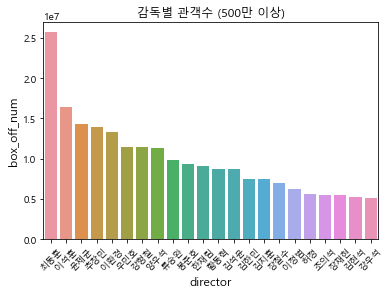

In [42]:
# 감독별 관객 수 그래프 (500만 이상)
dir_bfnum_500 = dir_bfnum[(dir_bfnum['box_off_num'] >= 5000000)]
dir_bfnum_500

dir_bfnum_500_plot = plt.subplots()
dir_bfnum_500_plot = sns.barplot(x='director', y='box_off_num', data=dir_bfnum_500)
plt.xticks(rotation=45, fontsize=9)
plt.yticks(fontsize=10)
dir_bfnum_500_plot.set_xlabel('director', fontsize=12)
dir_bfnum_500_plot.set_ylabel('box_off_num', fontsize=12)
dir_bfnum_500_plot.set_title("감독별 관객수 (500만 이상)", fontsize=12)

Text(0.5, 1.0, '감독별 관객수 (200만 이상 500만 미만)')

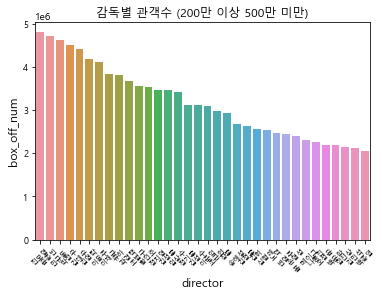

In [43]:
# 감독별 관객 수 그래프 (200만 이상 500만 미만)
dir_bfnum_200 = dir_bfnum[(dir_bfnum['box_off_num'] >= 2000000)]
dir_bfnum_200 = dir_bfnum_200[(dir_bfnum['box_off_num'] < 5000000)]

dir_bfnum_200_plot = plt.subplots()
dir_bfnum_200_plot = sns.barplot(x='director', y='box_off_num', data=dir_bfnum_200)
plt.xticks(rotation=45, fontsize=7)
plt.yticks(fontsize=9)
dir_bfnum_200_plot.set_xlabel('director', fontsize=12)
dir_bfnum_200_plot.set_ylabel('box_off_num', fontsize=12)
dir_bfnum_200_plot.set_title("감독별 관객수 (200만 이상 500만 미만)", fontsize=12)

Text(0.5, 1.0, '감독별 관객수 (100만 이상 200만 미만)')

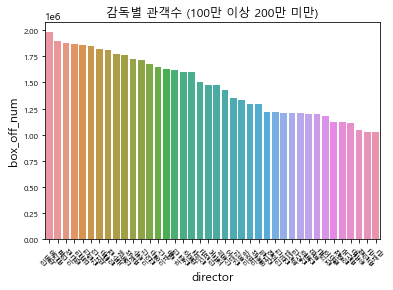

In [44]:
# 감독별 관객 수 그래프 (100만 이상 200만 미만)
dir_bfnum_100 = dir_bfnum[(dir_bfnum['box_off_num'] >= 1000000)]
dir_bfnum_100 = dir_bfnum_100[(dir_bfnum['box_off_num'] < 2000000)]

dir_bfnum_100_plot = plt.subplots()
dir_bfnum_100_plot = sns.barplot(x='director', y='box_off_num', data=dir_bfnum_100)
plt.xticks(rotation=45, fontsize=7)
plt.yticks(fontsize=8)
dir_bfnum_100_plot.set_xlabel('director', fontsize=12)
dir_bfnum_100_plot.set_ylabel('box_off_num', fontsize=12)
dir_bfnum_100_plot.set_title("감독별 관객수 (100만 이상 200만 미만)", fontsize=12)

Text(0.5, 1.0, '감독별 관객수 (50만 이상 100만 미만)')

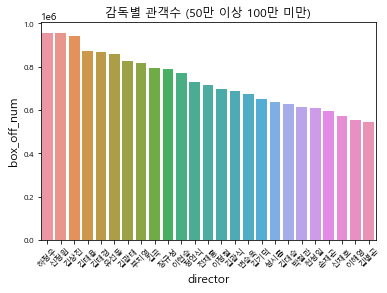

In [45]:
# 감독별 관객 수 그래프 (50만 이상 100만 미만)
dir_bfnum_50 = dir_bfnum[(dir_bfnum['box_off_num'] >= 500000)]
dir_bfnum_50 = dir_bfnum_50[(dir_bfnum['box_off_num'] < 1000000)]

dir_bfnum_50_plot = plt.subplots()
dir_bfnum_50_plot = sns.barplot(x='director', y='box_off_num', data=dir_bfnum_50)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
dir_bfnum_50_plot.set_xlabel('director', fontsize=12)
dir_bfnum_50_plot.set_ylabel('box_off_num', fontsize=12)
dir_bfnum_50_plot.set_title("감독별 관객수 (50만 이상 100만 미만)", fontsize=12)

* 감독별 관객 수는 1부터 25690504까지로 범위가 굉장히 넓다.

In [46]:
# 감독별 평균 관객 수
dir_bfnum_avg = movies_train[['director','box_off_num']].groupby('director').mean().sort_values('box_off_num').reset_index()
dir_bfnum_avg.columns = ['director','box_off_num']
dir_bfnum_avg.sort_values(by=['box_off_num'],ascending=False)

,director,box_off_num
471,윤제균,14262766.0
470,최동훈,12845252.0
469,양우석,11374879.0
468,봉준호,9350351.0
467,한재림,9135806.0
...,...,...
4,진광교,36.0
3,이세일,10.0
2,고구마,8.0
1,김정호,2.0


In [47]:
# 관객 수별 감독 수
bins_dir_bfnum = list(range(0, 27000000, 1000000)) # 구간 나누기
bins_label = [str("%g" %(x/10000))+"만 이상 "+str("%g" %(x/10000+100))+"만 미만" for x in bins_dir_bfnum]

dir_bfnum["level"] = pd.cut(dir_bfnum["box_off_num"], bins_dir_bfnum, right=False, labels=bins_label[:-1])

by_counts_dir_bfnum = pd.DataFrame(dir_bfnum['level'].value_counts()).reset_index()
by_counts_dir_bfnum.columns = ['level','level_counts']
by_counts_dir_bfnum.sort_values(by=['level'])

,level,level_counts
0,0만 이상 100만 미만,376
1,100만 이상 200만 미만,40
2,200만 이상 300만 미만,16
3,300만 이상 400만 미만,11
4,400만 이상 500만 미만,7
5,500만 이상 600만 미만,5
9,600만 이상 700만 미만,2
10,700만 이상 800만 미만,2
11,800만 이상 900만 미만,2
6,900만 이상 1000만 미만,3


Text(0.5, 1.0, '관객 수별 감독 수')

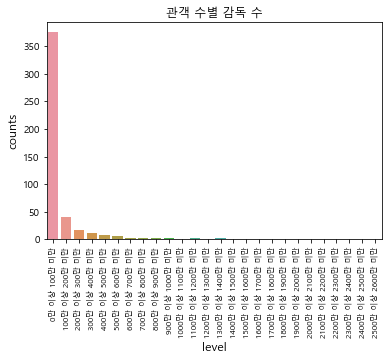

In [48]:
# 관객 수별 감독 수 그래프
by_counts_dir_bfnum_plot = plt.subplots()
by_counts_dir_bfnum_plot = sns.barplot(x='level', y='level_counts', data=by_counts_dir_bfnum)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=10)
by_counts_dir_bfnum_plot.set_xlabel('level', fontsize=12)
by_counts_dir_bfnum_plot.set_ylabel('counts', fontsize=12)
by_counts_dir_bfnum_plot.set_title("관객 수별 감독 수", fontsize=12)

* 관객 수가 100만 미만인 감독 수가 가장 많고, 1700만 미만인 범위에 대부분이 분포하고 있다.

### 7. dir_prev_bfnum
#### : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객 수(단 관객 수가 알려지지 않은 영화 제외)

In [49]:
# 감독별 평균 관객 수가 가장 많은 경우를 선택
dir_prev_counts_max = movies_train[['director','dir_prev_bfnum']].groupby('director').max().reset_index()
dir_prev_counts_max.columns=['director','dir_prev_bfnum']
dir_prev_counts_max

,director,dir_prev_bfnum
0,New Pistol,0.0
1,강석필,0.0
2,강성옥,0.0
3,강우석,844821.0
4,강의석,0.0
...,...,...
467,황석호,0.0
468,황욱,0.0
469,황유식,506419.0
470,황인호,1264761.5


In [50]:
dir_prev_counts_max['dir_prev_bfnum'].max()

17615314.0

In [51]:
# 평균 관객 수(최대값)별 감독 수 
bins_prev_bfnum_avg = list(range(0, 19000000, 1000000)) # 구간 나누기
bins_label = [str("%g" %(x/10000))+"만 이상 "+str("%g" %(x/10000+100))+"만 미만" for x in bins_prev_bfnum_avg]

dir_prev_counts_max["level"] = pd.cut(dir_prev_counts_max["dir_prev_bfnum"], bins_prev_bfnum_avg, right=False, labels=bins_label[:-1])

by_counts_bfnum = pd.DataFrame(dir_prev_counts_max['level'].value_counts()).reset_index()
by_counts_bfnum.columns = ['level','level_counts']
by_counts_bfnum

,level,level_counts
0,0만 이상 100만 미만,399
1,100만 이상 200만 미만,40
2,200만 이상 300만 미만,15
3,300만 이상 400만 미만,5
4,500만 이상 600만 미만,4
5,400만 이상 500만 미만,3
6,600만 이상 700만 미만,2
7,800만 이상 900만 미만,2
8,700만 이상 800만 미만,1
9,1700만 이상 1800만 미만,1


Text(0.5, 1.0, '평균 관객 수(최댓값)별 감독 수')

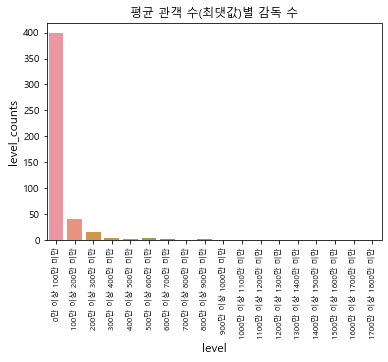

In [52]:
# 평균 관객 수(최댓값)별 감독 수 그래프
by_counts_bfnum_plot = plt.subplots()
by_counts_bfnum_plot = sns.barplot(x='level', y='level_counts', data=by_counts_bfnum)
plt.xticks(rotation=90, fontsize=8)
by_counts_bfnum_plot.set_xlabel('level', fontsize=12)
by_counts_bfnum_plot.set_ylabel('level_counts', fontsize=12)
by_counts_bfnum_plot.set_title("평균 관객 수(최댓값)별 감독 수", fontsize=12)

In [53]:
# 1천 미만인 경우
bins_prev_bfnum_avg_2 = list(range(0, 1100, 100)) # 구간 나누기
bins_label_2 = [str(x)+"이상 "+str(x+100)+"미만" for x in bins_prev_bfnum_avg_2]

dir_prev_counts_max["level"] = pd.cut(dir_prev_counts_max["dir_prev_bfnum"], bins_prev_bfnum_avg_2, right=False, labels=bins_label_2[:-1])

by_counts_bfnum_below = pd.DataFrame(dir_prev_counts_max['level'].value_counts()).reset_index()
by_counts_bfnum_below.columns = ['level','level_counts']
by_counts_bfnum_below.sort_values(by=['level'])

,level,level_counts
0,0이상 100미만,258
7,100이상 200미만,2
6,200이상 300미만,2
2,300이상 400미만,4
5,400이상 500미만,2
8,500이상 600미만,1
9,600이상 700미만,0
3,700이상 800미만,3
1,800이상 900미만,4
4,900이상 1000미만,2


In [54]:
dir_prev_counts_max[(dir_prev_counts_max['dir_prev_bfnum'] == 0)].count() # dir_prev_bfnum 이 0인 경우가 250건

director          250
dir_prev_bfnum    250
level             250
dtype: int64

In [55]:
# 극단값
dir_prev_counts_max[(dir_prev_counts_max['dir_prev_bfnum'] > 17000000)]

,director,dir_prev_bfnum,level
10,고구마,17615314.0,NaN


* 해당 감독이 처음 제작에 참여한 영화이거나 관객수가 알려지지 않은 경우가 대부분이다. 

Text(0.5, 1.0, 'dir_prev_bfnum와 관객 수의 관계')

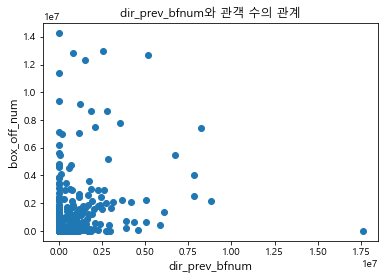

In [56]:
# dir_prev_bfnum와 관객 수의 관계 그래프
bfnum_scatter = plt.figure()
dir_prev_bfnum_plot = bfnum_scatter.add_subplot(1,1,1)
dir_prev_bfnum_plot.scatter(movies_train['dir_prev_bfnum'],movies_train['box_off_num'])
dir_prev_bfnum_plot.set_xlabel('dir_prev_bfnum', fontsize=12)
dir_prev_bfnum_plot.set_ylabel('box_off_num', fontsize=12)
dir_prev_bfnum_plot.set_title("dir_prev_bfnum와 관객 수의 관계", fontsize=12)

* dir_prev_bfnum과 관객 수 간 상관관계가 없다.

### 8. dir_prev_num
#### : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)

In [57]:
# 감독별 제작에 참여한 영화의 개수가 가장 많은 경우를 선택
dir_prev_num_max = movies_train[['director','dir_prev_num']].groupby('director').max().reset_index()
dir_prev_num_max.columns=['director','dir_prev_num']
dir_prev_num_max.sort_values(by=['dir_prev_num'],ascending=False)

,director,dir_prev_num
324,이해영,5
118,김휘,5
98,김진영,5
325,이해준,5
192,백승창,4
...,...,...
193,백승화,0
190,백승기,0
189,백동훈,0
187,배창호,0


In [58]:
# 제작에 참여한 영화 개수(최댓값)별 감독 수 
dir_prev_num_avg = pd.DataFrame(dir_prev_num_max['dir_prev_num'].value_counts()).reset_index()
dir_prev_num_avg.columns = ['num_prev_movies','dir_counts']
dir_prev_num_avg

,num_prev_movies,dir_counts
0,0,250
1,1,95
2,2,68
3,3,36
4,4,19
5,5,4


Text(0.5, 1.0, '제작에 참여한 영화 개수(최댓값)별 감독 수')

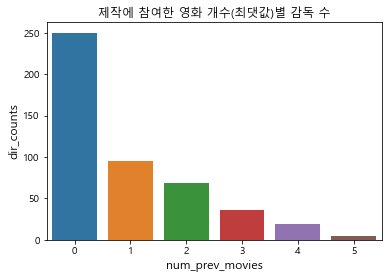

In [59]:
# 제작에 참여한 영화 개수(최댓값)별 감독 수 그래프
dir_prev_num_avg_plot = plt.subplots()
dir_prev_num_avg_plot = sns.barplot(x='num_prev_movies', y='dir_counts', data=dir_prev_num_avg)
plt.xticks(fontsize=10)
dir_prev_num_avg_plot.set_xlabel('num_prev_movies', fontsize=12)
dir_prev_num_avg_plot.set_ylabel('dir_counts', fontsize=12)
dir_prev_num_avg_plot.set_title("제작에 참여한 영화 개수(최댓값)별 감독 수", fontsize=12)

* 해당 감독이 처음 제작에 참여한 영화이거나 관객 수가 알려지지 않은 경우가 대부분이다.

Text(0.5, 1.0, 'dir_prev_num와 관객 수의 관계')

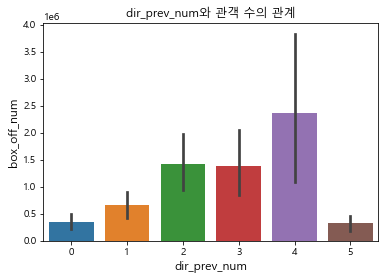

In [60]:
# dir_prev_num와 관객 수의 관계 그래프
dir_prev_dfnum_plot = plt.subplots()
dir_prev_dfnum_plot = sns.barplot(x='dir_prev_num', y='box_off_num', data=movies_train)
dir_prev_dfnum_plot.set_xlabel('dir_prev_num', fontsize=12)
dir_prev_dfnum_plot.set_ylabel('box_off_num', fontsize=12)
dir_prev_dfnum_plot.set_title("dir_prev_num와 관객 수의 관계", fontsize=12)

Text(0.5, 1.0, 'dir_prev_num와 관객 수의 관계')

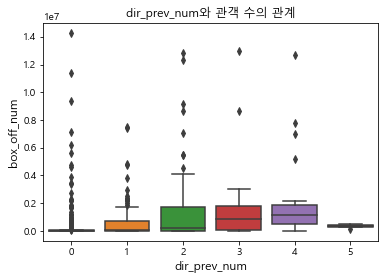

In [61]:
dir_prev_dfnum_plot_2 = plt.subplots()
dir_prev_dfnum_plot_2 = sns.boxplot(x='dir_prev_num', y='box_off_num', data=movies_train)
dir_prev_dfnum_plot_2.set_xlabel('dir_prev_num', fontsize=12)
dir_prev_dfnum_plot_2.set_ylabel('box_off_num', fontsize=12)
dir_prev_dfnum_plot_2.set_title("dir_prev_num와 관객 수의 관계", fontsize=12)

* dir_prev_num이 5인 경우를 제외하고는 dir_prev_num이 많을수록 관객 수의 중간값이 높다.

### 9. num_staff : 스태프 수

In [62]:
# 스태프 수별 영화 수
staff_counts=pd.DataFrame(movies_train['num_staff'].value_counts()).reset_index()
staff_counts.columns=['num_staff','counts']
staff_counts=staff_counts.sort_values(by="num_staff", ascending=True)
staff_counts

,num_staff,counts
0,0,32
1,1,15
2,2,15
3,3,12
9,4,7
...,...,...
206,683,1
205,687,1
204,719,1
248,868,1


Text(0.5, 1.0, '스태프 수별 영화 수')

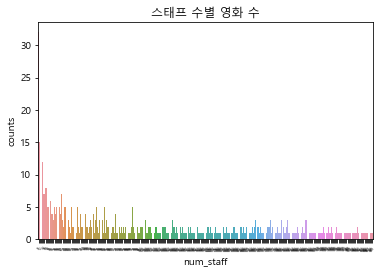

In [63]:
# 스태프 수별 영화 수 그래프
bar_staff_counts=plt.subplots()
plt.xticks(rotation = 50, fontsize=3)
bar_staff_counts=sns.barplot(x='num_staff',y='counts',data=staff_counts)
bar_staff_counts.set_title("스태프 수별 영화 수", fontsize=12)

In [64]:
# 스태프 수 범주화해서 다시 확인
bins2 = list(range(0, 870, 30)) # 구간 나누기
bins2_label = [str(x)+"이상 "+str(x+30)+"미만" for x in bins2]
movies_train["level2"] = pd.cut(movies_train["num_staff"], bins2, right=False, labels=bins2_label[:-1])

In [65]:
# 스태프 수 구간별 영화 수 데이터프레임 만들기
staff_movie_counts=movies_train['level2'].value_counts()
staff_movie_counts=pd.DataFrame(movies_train['level2'].value_counts()).reset_index()
staff_movie_counts.columns=['level2','counts']
staff_movie_counts

,level2,counts
0,0이상 30미만,199
1,30이상 60미만,66
2,90이상 120미만,43
3,60이상 90미만,41
4,120이상 150미만,28
5,240이상 270미만,24
6,330이상 360미만,24
7,270이상 300미만,23
8,300이상 330미만,23
9,180이상 210미만,20


Text(0.5, 1.0, '스태프 수 구간별 영화 수')

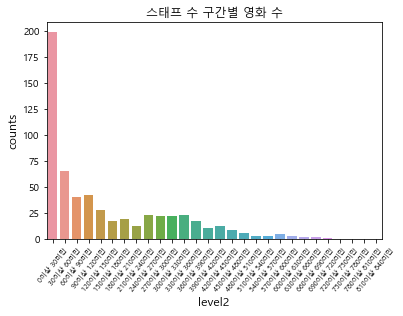

In [66]:
# 스태프 수 구간별 영화 수 그래프
bar_staff_movie_counts=plt.subplots()
plt.xticks(rotation = 50, fontsize=7)
bar_staff_movie_counts=sns.barplot(x='level2',y='counts',data=staff_movie_counts)
bar_staff_movie_counts.set_xlabel('level2', fontsize=12)
bar_staff_movie_counts.set_ylabel('counts', fontsize=12)
bar_staff_movie_counts.set_title("스태프 수 구간별 영화 수", fontsize=12)

* 전체 600개의 영화 중 약 200개가 30명 이하의 스태프를 동원했다. 스태프 수가 약 400명 이상인 경우는 거의 드물다.

In [67]:
# 스태프 수와 관객 수의 상관관계
movies_train[["num_staff","box_off_num"]].corr(method='pearson')

,num_staff,box_off_num
num_staff,1.0,0.5
box_off_num,0.5,1.0


<AxesSubplot:xlabel='num_staff', ylabel='box_off_num'>

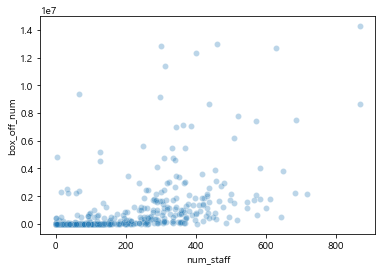

In [68]:
# 스태프 수와 관객 수의 관계 그래프
sns.scatterplot(data=movies_train, x='num_staff', y='box_off_num', alpha=0.3)

<AxesSubplot:xlabel='num_staff', ylabel='box_off_num'>

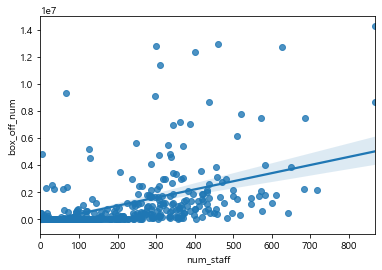

In [69]:
sns.regplot(data=movies_train, x='num_staff', y='box_off_num')

* 높은 관객 수를 기록한 영화의 스태프 수는 그 분포가 다양하지만, 관객 수 상위권의 영화들은 약 300명 이상의 스태프를 동원한 것으로 보인다.

### 10. num_actor : 주연배우 수

In [70]:
# 주연배우 수별 영화 수
actor_counts=pd.DataFrame(movies_train['num_actor'].value_counts()).reset_index()
actor_counts.columns=['num_actor','counts']
actor_counts=actor_counts.sort_values(by="num_actor", ascending=True)
actor_counts

,num_actor,counts
8,0,9
4,1,35
0,2,154
1,3,143
2,4,114
3,5,58
5,6,33
7,7,16
6,8,16
11,9,3


Text(0.5, 1.0, '주연배우 수별 영화 수')

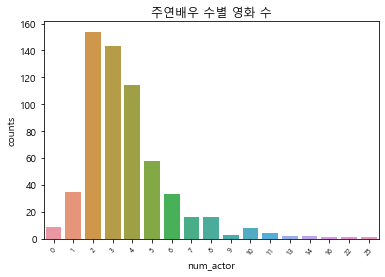

In [71]:
# 주연배우 수별 영화 수 그래프
bar_actor_counts=plt.subplots()
plt.xticks(rotation = 50, fontsize=7)
bar_actor_counts=sns.barplot(x='num_actor',y='counts',data=actor_counts)
bar_staff_movie_counts.set_xlabel('num_actor', fontsize=12)
bar_staff_movie_counts.set_ylabel('counts', fontsize=12)
bar_actor_counts.set_title("주연배우 수별 영화 수", fontsize=12)

* 주연배우가 2명, 3명, 4명인 순으로 영화가 많고 전체 영화 수의 약 70%를 차지한다.

In [72]:
# 주연배우 수와 관객 수의 상관관계
movies_train[["num_actor","box_off_num"]].corr(method='pearson')

,num_actor,box_off_num
num_actor,1.0,0.1
box_off_num,0.1,1.0


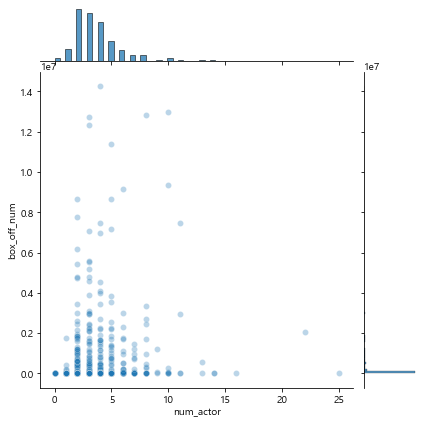

In [73]:
# 주연배우 수와 관객 수의 관계 그래프
sns.jointplot(data=movies_train, x='num_actor', y='box_off_num', alpha=0.3)

<AxesSubplot:xlabel='num_actor', ylabel='box_off_num'>

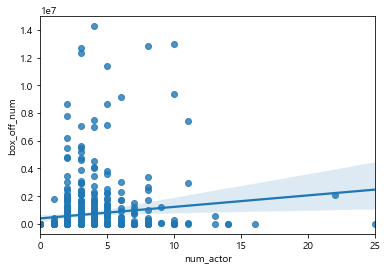

In [74]:
sns.regplot(data=movies_train, x='num_actor', y='box_off_num')

## 2. 관객수 예측 모델링

### 1. basemodel 결정

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
#Rmsle계산 함수 제작
def rmsle(y,pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    squared_error=(log_y-log_pred)**2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle

# Rsme 계산 함수
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    rmsle_val=rmsle(y,pred)
    rmse_val=rmse(y,pred)
    mae_val=mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3f}'.format(rmsle_val,rmse_val,mae_val))

In [76]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor 

y_target=movies_train['box_off_num']
X_features=movies_train[['time','dir_prev_num', 'num_staff', 'num_actor','genre']]
X_train,X_test,y_train,y_test=train_test_split(X_features,y_target,test_size=0.3,random_state=132)

In [77]:
# 장르 변수 원핫 인코딩 적용 데이터로 학습/예측 데이터 분할
X_features_ohe=pd.get_dummies(X_features,columns=['genre'])
X_features_ohe=pd.get_dummies(X_features,columns=['genre'])
X_train,X_test,y_train,y_test=train_test_split(X_features_ohe,y_target,test_size=0.3,random_state=0)

def get_model_predict(model,X_train,X_test,y_train,y_test,is_expm1=False):
    model.fit(X_train,y_train)
    pred=model.predict(X_test)
    if is_expm1:
        y_test=np.expm1(y_test)
        pred=np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test,pred)
    

<AxesSubplot:>

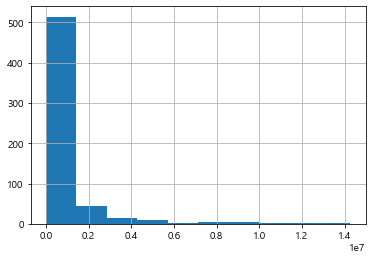

In [78]:
#box_off_num의 분포 확인
y_target.hist()

<AxesSubplot:>

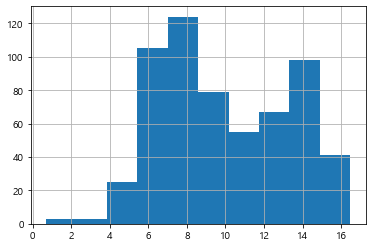

In [79]:
#box_off_num의 정규화 (로그변환)
y_log_transform=np.log1p(y_target)
y_log_transform.hist()

In [80]:
#타겟 칼럼 box_off_num값 log1p로 로그 변환 후 재학습
y_target_log=np.log1p(y_target)
X_train,X_test,y_train,y_test=train_test_split(X_features_ohe,y_target_log,test_size=0.3,random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train,y_train)
pred=lr_reg.predict(X_test)

#로그 변환된 target값,예측값 원 스케일로 변환
y_test_exp=np.expm1(y_test)
pred_exp=np.expm1(pred)
evaluate_regr(y_test_exp,pred_exp)

RMSLE: 2.160, RMSE: 27857854.661, MAE: 3324216.308


In [81]:
#회귀 트리 이용 회귀 예측
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


rf_reg=RandomForestRegressor(n_estimators=600)
gbm_reg=GradientBoostingRegressor(n_estimators=600)
xgb_reg=XGBRegressor(n_estimators=600)
lgbm_reg=lgb.LGBMRegressor(random_state=123, n_estimators=1000, learning_rate= 0.003, min_child_samples=30)

for model in [rf_reg,gbm_reg,xgb_reg,lgbm_reg]:
    get_model_predict(model,X_train.values,X_test.values,y_train.values,y_test.values,is_expm1=True)


### RandomForestRegressor ###
RMSLE: 2.022, RMSE: 1697378.016, MAE: 535745.373
### GradientBoostingRegressor ###
RMSLE: 2.240, RMSE: 1721636.257, MAE: 565459.171
### XGBRegressor ###
RMSLE: 2.175, RMSE: 1703504.663, MAE: 541423.681
### LGBMRegressor ###
RMSLE: 2.009, RMSE: 1722075.779, MAE: 504335.464


#### LGBMRegressor와 RandomForestRegressor의 rmsle, mae 값이 작게 나옴 -> basemodel로 채택

------------------------------------------------------------------------------------------------------------------------

### 2. LightGBM

In [82]:
model = lgb.LGBMRegressor(random_state=123, n_estimators=1000)

In [83]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor']
target = ['box_off_num']

In [84]:
X_train, X_test, y_train = movies_train[features], movies_test[features], movies_train[target]

In [85]:
model.fit(X_train, y_train)

LGBMRegressor(n_estimators=1000, random_state=123)

In [86]:
singleLGBM = movies_submission.copy()
singleLGBM['box_off_num'] = model.predict(X_test)
singleLGBM.to_csv('singleLGBM.csv', index = False)
singleLGBM.head()

,title,box_off_num
0,용서는 없다,2817995.2
1,아빠가 여자를 좋아해,375377.2
2,하모니,-569324.3
3,의형제,1581189.0
4,평행 이론,-527780.6


### 2-1. k-fold 교차검증

In [87]:
from sklearn.model_selection import KFold

In [88]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=123)

In [89]:
model = lgb.LGBMRegressor(random_state=123, n_estimators=1000)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set =(x_val, y_val), early_stopping_rounds=100, verbose = 100))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.20394e+12
Early stopping, best iteration is:
[37]	valid_0's l2: 3.02539e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.26173e+12
Early stopping, best iteration is:
[6]	valid_0's l2: 1.65838e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 9.17903e+11
Early stopping, best iteration is:
[21]	valid_0's l2: 8.49509e+11
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.28177e+12
Early stopping, best iteration is:
[9]	valid_0's l2: 2.08241e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.32139e+12
Early stopping, best iteration is:
[94]	valid_0's l2: 3.31907e+12


In [90]:
models

[LGBMRegressor(n_estimators=1000, random_state=123),
 LGBMRegressor(n_estimators=1000, random_state=123),
 LGBMRegressor(n_estimators=1000, random_state=123),
 LGBMRegressor(n_estimators=1000, random_state=123),
 LGBMRegressor(n_estimators=1000, random_state=123)]

In [91]:
preds = []
for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [92]:
kfoldLightGBM = movies_submission.copy()
kfoldLightGBM['box_off_num'] = np.mean(preds, axis = 0)
kfoldLightGBM.to_csv('kfoldLightGBM.csv', index = False)
kfoldLightGBM.head()

,title,box_off_num
0,용서는 없다,3342389.6
1,아빠가 여자를 좋아해,1091181.5
2,하모니,60913.0
3,의형제,1604975.4
4,평행 이론,1011963.8


### 2-2. feature engineering

In [93]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
movies_train['genre'] = le.fit_transform(movies_train['genre'])

In [94]:
movies_train['genre']

0      10
1       2
2      10
3      11
4      11
       ..
595     4
596     4
597     1
598     2
599    10
Name: genre, Length: 600, dtype: int32

In [95]:
movies_test['genre'] = le.transform(movies_test['genre'])

In [96]:
features = ['time', 'dir_prev_num', 'num_staff', 'num_actor', 'dir_prev_bfnum', 'genre']

In [97]:
X_train, X_test, y_train = movies_train[features], movies_test[features], movies_train[target]

In [98]:
model = lgb.LGBMRegressor(random_state=123, n_estimators=1000)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose= 100))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.18117e+12
Early stopping, best iteration is:
[31]	valid_0's l2: 2.88521e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.19085e+12
Early stopping, best iteration is:
[7]	valid_0's l2: 1.61496e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 9.22976e+11
Early stopping, best iteration is:
[48]	valid_0's l2: 8.69332e+11
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.37487e+12
Early stopping, best iteration is:
[8]	valid_0's l2: 2.12748e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.44921e+12
Early stopping, best iteration is:
[65]	valid_0's l2: 3.40972e+12


In [99]:
preds = []
for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [100]:
feLightGBM = movies_submission.copy()

In [101]:
feLightGBM['box_off_num'] = np.mean(preds, axis = 0)

In [102]:
feLightGBM.to_csv('feLightGBM.csv', index = False)

### 2-3. Grid Search

In [103]:
from sklearn.model_selection import GridSearchCV

In [104]:
model = lgb.LGBMRegressor(random_state=123, n_estimators=1000)

params = {
    'learning_rate': [0.1, 0.01, 0.003],
    'min_child_samples': [20, 30]}

gs = GridSearchCV(estimator=model,
                 param_grid=params,
                 scoring='neg_mean_squared_error',
                 cv = 5)

In [105]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(n_estimators=1000, random_state=123),
             param_grid={'learning_rate': [0.1, 0.01, 0.003],
                         'min_child_samples': [20, 30]},
             scoring='neg_mean_squared_error')

In [106]:
gs.best_params_

{'learning_rate': 0.003, 'min_child_samples': 30}

In [107]:
model = lgb.LGBMRegressor(random_state=123, n_estimators=1000, learning_rate= 0.003, min_child_samples=30)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose= 100))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.92398e+12
[200]	valid_0's l2: 3.49969e+12
[300]	valid_0's l2: 3.25633e+12
[400]	valid_0's l2: 3.11167e+12
[500]	valid_0's l2: 3.01271e+12
[600]	valid_0's l2: 2.96636e+12
[700]	valid_0's l2: 2.95444e+12
[800]	valid_0's l2: 2.94077e+12
[900]	valid_0's l2: 2.93296e+12
[1000]	valid_0's l2: 2.91385e+12
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 2.91385e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.81776e+12
[200]	valid_0's l2: 1.68594e+12
[300]	valid_0's l2: 1.66547e+12
[400]	valid_0's l2: 1.65515e+12
Early stopping, best iteration is:
[378]	valid_0's l2: 1.65359e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.08326e+12
[200]	valid_0's l2: 9.45851e+11
[300]	valid_0's l2: 8.83744e+11
[400]	valid_0's l2: 8.68284e+11
Early stopping, best iteration is:
[397]	valid_0's l2: 8.68187e+11
Training until validat

In [108]:
preds = []
for model in models:
    preds.append(model.predict(X_test))

In [109]:
gs.best_score_

-2149326154919.0142

In [110]:
gslgbm = movies_submission.copy()
gslgbm['box_off_num'] = np.mean(preds, axis =0)
gslgbm.to_csv('gslgbm.csv', index = False)
gslgbm.head()

,title,box_off_num
0,용서는 없다,3475940.8
1,아빠가 여자를 좋아해,630268.7
2,하모니,1393981.3
3,의형제,1110960.5
4,평행 이론,1269216.0


------------------------------------------------------------

### 3. Random Forest

In [111]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 518)

In [112]:
rmse_list = []
rf_pred = np.zeros((movies_test.shape[0]))
for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

In [113]:
rf.fit(x_t, y_t)

RandomForestRegressor(random_state=518)

In [114]:
from sklearn.metrics import mean_squared_error
pred = rf.predict(x_val)
rmse = np.sqrt(mean_squared_error(y_val, pred))

In [115]:
rmse_list.append(rmse)
np.mean(rmse_list)

2016905.945429561

In [116]:
rf_pred = movies_submission.copy()
rf_pred['box_off_num'] = rf.predict(X_test)
rf_pred.to_csv('rf.csv', index = False)

In [117]:
### Random Forest

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 518)

rmse_list = []
rf_pred = np.zeros((movies_test.shape[0]))
for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

rf.fit(x_t, y_t)

from sklearn.metrics import mean_squared_error
pred = rf.predict(x_val)
rmse = np.sqrt(mean_squared_error(y_val, pred))

rmse_list.append(rmse)
np.mean(rmse_list)

rf_pred = movies_submission.copy()
rf_pred['box_off_num'] = rf.predict(X_test)
rf_pred.to_csv('rf.csv', index = False)
rf_pred.head()

,title,box_off_num
0,용서는 없다,3978644.7
1,아빠가 여자를 좋아해,1260294.1
2,하모니,1377630.9
3,의형제,1705449.4
4,평행 이론,1396497.8
